## Importing libraries

In [46]:
import pandas as pd
import numpy as np
import requests

In [2]:
import gcsfs

In [12]:
import time

In [154]:
import glob

In [3]:
import pyarrow

In [24]:
from tqdm import tqdm_notebook

In [27]:
import pyspark

In [5]:
from dask.distributed import Client, progress, LocalCluster
import dask

In [8]:
import dask.dataframe as dd

In [130]:
import matplotlib.pyplot as plt
%matplotlib inline

## Gathering data

In [3]:
url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-01.csv'

In [4]:
first_df = pd.read_csv(url)
first_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,4.5,0.5,0.5,0.00,0.0,0.3,5.80
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,14.0,0.5,0.5,0.00,0.0,0.3,15.30
2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,6.0,0.5,0.5,1.00,0.0,0.3,8.30
3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,1,N,140,257,2,33.5,0.5,0.5,0.00,0.0,0.3,34.80
4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55


In [5]:
first_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8759874 entries, 0 to 8759873
Data columns (total 17 columns):
VendorID                 int64
tpep_pickup_datetime     object
tpep_dropoff_datetime    object
passenger_count          int64
trip_distance            float64
RatecodeID               int64
store_and_fwd_flag       object
PULocationID             int64
DOLocationID             int64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 1.1+ GB


Save data for January 2018

In [10]:
first_df.to_csv('gs://nyc-taxi-data-2018-2019/yellow_tripdata_2018-01.csv')

#### Iterate through each month to gather yellow taxi data for whole 2018

In [ ]:
start_time = time.time()

for i in tqdm_notebook(['02','03','04', '05', '06', '07', '08', '09', '10', '11', '12']):
    url = f'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-{i}.csv'
    df = pd.read_csv(url)
    df.to_csv(f'gs://nyc-taxi-data-2018-2019/yellow_tripdata_2018-{i}.csv')

print("--- %s seconds ---" % (time.time() - start_time))

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



--- 1564.2293634414673 seconds ---


#### Verification if everything works

In [37]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [11]:
gs_path = 'gs://nyc-taxi-data-2018-2019'

In [43]:
months = ['01','02', '03','04', '05', '06', '07', '08', '09', '10', '11', '12']
full_2018 = [gs_path + f'/yellow_tripdata_2018-{i}.csv' for i in months]

In [44]:
full_2018

['gs://nyc-taxi-data-2018-2019/yellow_tripdata_2018-01.csv',
 'gs://nyc-taxi-data-2018-2019/yellow_tripdata_2018-02.csv',
 'gs://nyc-taxi-data-2018-2019/yellow_tripdata_2018-03.csv',
 'gs://nyc-taxi-data-2018-2019/yellow_tripdata_2018-04.csv',
 'gs://nyc-taxi-data-2018-2019/yellow_tripdata_2018-05.csv',
 'gs://nyc-taxi-data-2018-2019/yellow_tripdata_2018-06.csv',
 'gs://nyc-taxi-data-2018-2019/yellow_tripdata_2018-07.csv',
 'gs://nyc-taxi-data-2018-2019/yellow_tripdata_2018-08.csv',
 'gs://nyc-taxi-data-2018-2019/yellow_tripdata_2018-09.csv',
 'gs://nyc-taxi-data-2018-2019/yellow_tripdata_2018-10.csv',
 'gs://nyc-taxi-data-2018-2019/yellow_tripdata_2018-11.csv',
 'gs://nyc-taxi-data-2018-2019/yellow_tripdata_2018-12.csv']

In [45]:
df_2018 = spark.read.csv(full_2018[0], header=True)
for f in full_2018[1:]:
    temp_df = spark.read.csv(f, header=True)
    df_2018 = df_2018.union(temp_df)

In [47]:
def show(df, n=5):
    return df.limit(n).toPandas()

In [51]:
df_2018.count()

102804250

In [52]:
show(df_2018)

,_c0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,4.5,0.5,0.5,0.0,0.0,0.3,5.8
1,1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,14.0,0.5,0.5,0.0,0.0,0.3,15.3
2,2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,6.0,0.5,0.5,1.0,0.0,0.3,8.3
3,3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,1,N,140,257,2,33.5,0.5,0.5,0.0,0.0,0.3,34.8
4,4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55


In [55]:
df_2018.dtypes

[('_c0', 'string'),
 ('VendorID', 'string'),
 ('tpep_pickup_datetime', 'string'),
 ('tpep_dropoff_datetime', 'string'),
 ('passenger_count', 'string'),
 ('trip_distance', 'string'),
 ('RatecodeID', 'string'),
 ('store_and_fwd_flag', 'string'),
 ('PULocationID', 'string'),
 ('DOLocationID', 'string'),
 ('payment_type', 'string'),
 ('fare_amount', 'string'),
 ('extra', 'string'),
 ('mta_tax', 'string'),
 ('tip_amount', 'string'),
 ('tolls_amount', 'string'),
 ('improvement_surcharge', 'string'),
 ('total_amount', 'string')]

## Preparing dataset for whole NYC

### Picking columns for further use and converting everything to parquet files

In [24]:
cluster = LocalCluster(processes=True, n_workers=4)
client = Client(cluster)

/opt/conda/anaconda/lib/python3.6/site-packages/bokeh/themes/theme.py:94: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  json = yaml.load(f)
/opt/conda/anaconda/lib/python3.6/site-packages/distributed/dashboard/core.py:12: UserWarning: 
Dask needs bokeh >= 0.13.0 for the dashboard.
Continuing without the dashboard.
  "\nDask needs bokeh >= 0.13.0 for the dashboard."


In [6]:
dask.__version__

'2.8.0'

#### Converting to parquet to increase speed of operations

In [12]:
def conv_to_parq(i):
    df = dd.read_csv(f'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018-{i}.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
    df['store_and_fwd_flag'] = df.store_and_fwd_flag.apply(lambda x: 1 if x == "Y" else 0)
    df.to_parquet(f'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018/yellow_tripdata_2018-{i}.parquet', engine = 'pyarrow')

In [ ]:
y = []
for x in tqdm_notebook(['01','02','03','04', '05', '06', '07', '08', '09', '10', '11', '12']):
    y.append(dask.delayed(conv_to_parq)(x))
dask.compute(y)

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


([None, None, None, None, None, None, None, None, None, None],)

In [24]:
gcs = gcsfs.GCSFileSystem()
filelist = gcs.glob('nyc-taxi-data-2018-2019/yellow_tripdata_2018/*/*.parquet/')
filelist_gcs = ['gcs://' + x for x in filelist]

In [26]:
%time data_2018 = dd.read_parquet(filelist_gcs)

CPU times: user 2.24 s, sys: 184 ms, total: 2.42 s
Wall time: 18.9 s


In [29]:
len(data_2018)

102804250

In [30]:
data_2018.tail()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
index,,,,,,,,,,,,,,,,,,
510232,8173226,2,2018-12-31 23:40:45,2018-12-31 23:49:52,3,1.08,1,0,161,237,2,7.5,0.5,0.5,0.00,0.0,0.3,8.80
510233,8173227,2,2018-12-31 23:16:46,2018-12-31 23:28:09,2,2.68,1,0,263,24,1,11.0,0.5,0.5,4.92,0.0,0.3,17.22
510234,8173228,2,2018-12-31 23:29:01,2018-12-31 23:33:39,1,0.75,1,0,41,43,2,5.0,0.5,0.5,0.00,0.0,0.3,6.30
510235,8173229,2,2018-12-31 23:55:39,2018-12-31 23:59:15,1,0.92,1,0,263,75,1,5.0,0.5,0.5,1.26,0.0,0.3,7.56
510236,8173230,2,2018-12-31 23:13:26,2018-12-31 23:13:31,1,0.00,1,0,264,193,2,0.0,0.0,0.0,0.00,0.0,0.0,0.00


#### Choosing columns for further use

Start with January 2018

In [66]:
%time data_2018_01_par = dd.read_parquet('gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018/yellow_tripdata_2018-01.parquet/')

CPU times: user 188 ms, sys: 0 ns, total: 188 ms
Wall time: 340 ms


In [67]:
%time data_2018_01_par['tip_ratio'] = data_2018_01_par.tip_amount / data_2018_01_par.total_amount

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 15.9 ms


In [69]:
%time data_2018_01_par = data_2018_01_par[['tpep_pickup_datetime','trip_distance','fare_amount','tip_amount','total_amount','tip_ratio']].set_index('tpep_pickup_datetime')

CPU times: user 936 ms, sys: 76 ms, total: 1.01 s
Wall time: 8.52 s


In [70]:
%time data_2018_01_par['2018-01':'2018-01'].tail()

CPU times: user 816 ms, sys: 32 ms, total: 848 ms
Wall time: 8.45 s


,trip_distance,fare_amount,tip_amount,total_amount,tip_ratio
tpep_pickup_datetime,,,,,
2018-01-31 23:59:55,1.4,6.5,0.00,7.80,0.000000
2018-01-31 23:59:56,8.8,31.0,9.65,41.95,0.230036
2018-01-31 23:59:56,3.2,12.0,1.00,14.30,0.069930
2018-01-31 23:59:56,0.5,3.5,0.00,4.80,0.000000
2018-01-31 23:59:57,0.9,5.5,1.00,7.80,0.128205


In [71]:
%time data_2018_01_par = data_2018_01_par['2018-01':'2018-01']

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 12.2 ms


#### Calculating demand in whole NYC

In [78]:
%time demand_hr = data_2018_01_par['trip_distance'].resample('h').count()

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 10.5 ms


In [93]:
demand_hr = demand_hr.rename("demand")

#### Calculating total amount of tips and prices

In [79]:
%time total_hr = data_2018_01_par[['tip_amount','total_amount', 'fare_amount']].resample('h').sum()

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 15.9 ms


In [85]:
total_hr.columns = [str(col) + '_sum' for col in total_hr.columns]

#### Calculating average values of all picked columns

In [80]:
%time all_avg = data_2018_01_par.resample('h').mean()

CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 18.1 ms


In [88]:
all_avg.columns = [str(col) + '_avg' for col in all_avg.columns]

In [115]:
all_avg.columns

Index(['trip_distance_avg', 'fare_amount_avg', 'tip_amount_avg',
       'total_amount_avg', 'tip_ratio_avg'],
      dtype='object')

#### Combining dataframe

In [95]:
%time data_2018_01_par = dd.concat([demand_hr, total_hr, all_avg], axis=1)

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 39.3 ms


In [96]:
%time data_2018_01_par = data_2018_01_par.compute()

CPU times: user 2.44 s, sys: 52 ms, total: 2.5 s
Wall time: 17.3 s


In [97]:
data_2018_01_par.head()

,demand,tip_amount_sum,total_amount_sum,fare_amount_sum,trip_distance_avg,fare_amount_avg,tip_amount_avg,total_amount_avg,tip_ratio_avg
tpep_pickup_datetime,,,,,,,,,
2018-01-01 00:00:00,16458,26623.96,257503.82,207728.90,2.754618,12.621758,1.617691,15.646119,0.094985
2018-01-01 01:00:00,18985,32791.72,304282.14,244231.91,2.957461,12.864467,1.727244,16.027503,0.099037
2018-01-01 02:00:00,16561,28550.99,267512.86,215108.50,3.083759,12.988859,1.723989,16.153183,0.098159
2018-01-01 03:00:00,12611,20573.25,201875.63,163322.54,3.167346,12.950800,1.631373,16.007900,0.094318
2018-01-01 04:00:00,8726,13269.78,147613.79,121276.90,3.562889,13.898338,1.520717,16.916547,0.083468


Saving processed parquet file for January 2018

In [100]:
data_2018_01_par.to_parquet('gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-01.parquet', engine = 'pyarrow')

In [129]:
abs(data_2018_01_par.corr())

,demand,tip_amount_sum,total_amount_sum,fare_amount_sum,trip_distance_avg,fare_amount_avg,tip_amount_avg,total_amount_avg,tip_ratio_avg
demand,1.000000,0.979720,0.987778,0.989567,0.595388,0.554618,0.150473,0.469047,0.765966
tip_amount_sum,0.979720,1.000000,0.993010,0.987217,0.525642,0.459893,0.309449,0.348863,0.797833
total_amount_sum,0.987778,0.993010,1.000000,0.997394,0.538946,0.460975,0.259526,0.358516,0.752159
fare_amount_sum,0.989567,0.987217,0.997394,1.000000,0.546438,0.464381,0.235868,0.376433,0.745589
trip_distance_avg,0.595388,0.525642,0.538946,0.546438,1.000000,0.728843,0.308839,0.705171,0.529059
fare_amount_avg,0.554618,0.459893,0.460975,0.464381,0.728843,1.000000,0.507243,0.971319,0.618288
tip_amount_avg,0.150473,0.309449,0.259526,0.235868,0.308839,0.507243,1.000000,0.637106,0.312442
total_amount_avg,0.469047,0.348863,0.358516,0.376433,0.705171,0.971319,0.637106,1.000000,0.508839
tip_ratio_avg,0.765966,0.797833,0.752159,0.745589,0.529059,0.618288,0.312442,0.508839,1.000000


### Repeat all steps for other months of 2018

In [1]:
def create_hr_parq(month):
    df = dd.read_parquet(f'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018/yellow_tripdata_2018-{month}.parquet/')
    
    # calculate tip ratio
    df['tip_ratio'] = df.tip_amount / df.total_amount
    
    # choose columns
    df = df[['tpep_pickup_datetime','trip_distance','fare_amount','tip_amount','total_amount','tip_ratio']].set_index('tpep_pickup_datetime')
    rng = f'2018-{month}'
    df = df[rng:rng]
    
    # calculate demand
    demand_hr = df['trip_distance'].resample('h').count()
    demand_hr = demand_hr.rename("demand")
    
    # calculate total values
    total_hr = df[['tip_amount','total_amount', 'fare_amount']].resample('h').sum()
    total_hr.columns = [str(col) + '_sum' for col in total_hr.columns]
    
    # calculate average values
    all_avg = df.resample('h').mean()
    all_avg.columns = [str(col) + '_avg' for col in all_avg.columns]
    
    # combine dataframes
    df = dd.concat([demand_hr, total_hr, all_avg], axis=1)
    df = df.compute()
    df.to_parquet(f'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-{month}.parquet', engine = 'pyarrow')
    

In [153]:
for month in tqdm_notebook(['02','03','04', '05', '06', '07', '08', '09', '10', '11', '12']):
    create_hr_parq(month)

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


#### Verification if everything works

In [158]:
filelist = gcs.glob('nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/*.parquet/')
filelist_gcs = ['gcs://' + x for x in filelist]
filelist_gcs

['gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-01.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-02.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-03.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-04.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-05.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-06.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-07.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-08.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-09.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-10.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-11.parquet',
 'gcs://ny

In [159]:
%time data_hr_2018 = dd.read_parquet(filelist_gcs)

CPU times: user 228 ms, sys: 12 ms, total: 240 ms
Wall time: 1.11 s


Hourly and weekday average fare in whole NYC area

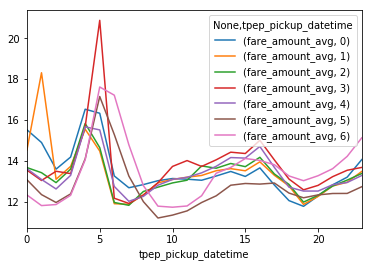

In [194]:
data_hr_2018_fare = data_hr_2018[[ 'fare_amount_avg']].groupby([data_hr_2018.index.hour,data_hr_2018.index.weekday]).mean().compute().unstack()
data_hr_2018_fare.plot()